In [85]:
#!pip install fastai --upgrade
#!pip install nbdev
#!pip install azure-cognitiveservices-search-imagesearch
from utils import *
from fastai.vision.all import *

In [4]:
# Download PASCAL dataset
path = untar_data(URLs.PASCAL_2007)

In [5]:
# Dataset comes with a .CSV file telling us labels for each image
df = pd.read_csv(path/'train.csv')

## Pandas and DataFrames

In [7]:
df.iloc[:,0]

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [8]:
df.iloc[0,:]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [9]:
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [10]:
df1 = pd.DataFrame()
df1['a'] = [1,2,3,4]

In [11]:
df1['b'] = [10,20,30,40]

In [12]:
#df1['a'] + df1['b']

### Lecture Content here

In [13]:
a = list(enumerate(string.ascii_lowercase))
a[0], len(a)

((0, 'a'), 26)

In [14]:
dl_a = DataLoader(a, batch_size=8, shuffle=True)
b = first(dl_a)
b

(tensor([ 7, 24, 17, 21,  5, 19,  9, 15]),
 ('h', 'y', 'r', 'v', 'f', 't', 'j', 'p'))

In [15]:
list(zip(b[0], b[1]))

[(tensor(7), 'h'),
 (tensor(24), 'y'),
 (tensor(17), 'r'),
 (tensor(21), 'v'),
 (tensor(5), 'f'),
 (tensor(19), 't'),
 (tensor(9), 'j'),
 (tensor(15), 'p')]

In [16]:
# Same as above
# *b - insert into this parameter list each element of b
list(zip(*b))

[(tensor(7), 'h'),
 (tensor(24), 'y'),
 (tensor(17), 'r'),
 (tensor(21), 'v'),
 (tensor(5), 'f'),
 (tensor(19), 't'),
 (tensor(9), 'j'),
 (tensor(15), 'p')]

In [17]:
a = list(string.ascii_lowercase)
a[0], len(a)

('a', 26)

In [18]:
dss = Datasets(a)
dss[0]

('a',)

In [19]:
def f1(o):
  return o+'a'

def f2(o):
  return o+'b'

In [20]:
dss = Datasets(a, [[f1]]) # list of transformations to do
dss[0]

('aa',)

In [21]:
dss = Datasets(a, [[f1, f2]])
dss[0]

('aab',)

In [22]:
dls = DataLoaders.from_dsets(dss, batch_size=4)
first(dls.train)

(('rab', 'sab', 'kab', 'wab'),)

In [23]:
dss = Datasets(a, [[f1], [f2]])
dss[0]
# This is how we do with fastai
# first function gets filename and opens image
# second function gets label

('aa', 'ab')

### Book Content here

In [24]:
# Data block created with no parameters
dblock = DataBlock()
dsets = dblock.datasets(df)

In [25]:
len(dsets.train), len(dsets.valid)

(4009, 1002)

In [26]:
x, y = dsets.train[0]
x,y
# Copies row from DataFrame twice

(fname         002786.jpg
 labels      horse person
 is_valid            True
 Name: 1401, dtype: object, fname         002786.jpg
 labels      horse person
 is_valid            True
 Name: 1401, dtype: object)

In [27]:
x['fname']

'002786.jpg'

In [28]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('007204.jpg', 'cat')

In [29]:
def get_x(r):
  return r['fname']

def get_y(r):
  return r['labels']

dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)

dsets.train[0]

('002848.jpg', 'motorbike')

In [30]:
# We need to convert filename into complete path
# We also need to split categories on space

Path.BASE_PATH = path

def get_x(r):
  return path/'train'/r['fname']

def get_y(r):
  return r['labels'].split(' ')

dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)

dsets.train[0]

(Path('train/004010.jpg'), ['sofa', 'person'])

In [31]:
dblock = DataBlock(blocks= (ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)

dsets = dblock.datasets(df)

dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]))

In [32]:
# Let's check which categories are represented in this example
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#2) ['car','person']

By default, DataBlock uses a random split. To explicitly choose the elements of our validation set, we need to write a function and pass it to `splitter`. It will take the items and return two or more lists of integers

In [33]:
def splitter(df):
  train = df.index[~df['is_valid']].tolist()
  valid = df.index[df['is_valid']].tolist()
  return train,valid

dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                   splitter = splitter,
                   get_x = get_x,
                   get_y = get_y)

dsets = dblock.datasets(df)

dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

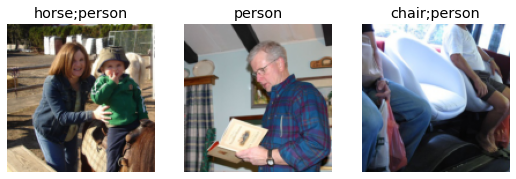

In [34]:
dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                   splitter = splitter,
                   get_x = get_x,
                   get_y = get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))

dls = dblock.dataloaders(df)

dls.show_batch(nrows=1, ncols=3)

In [35]:
#dblock.summary(df)

## Binary Cross Entropy

In [36]:
learn = cnn_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [37]:
x, y = dls.train.one_batch()
learn.model.cuda() # move training to GPU
activs = learn.model(x) # activations from final layer
activs.shape

torch.Size([64, 20])

In [38]:
activs[0]

tensor([ 1.7360, -2.8612, -0.9968, -0.9030,  2.5456, -1.0796,  3.2149, -4.3430,  0.5124, -0.1313, -1.0431, -1.6156, -2.6733,  0.1799,  0.0065, -2.5324,  5.4574, -1.0834,  0.8269,  1.8208],
       device='cuda:0', grad_fn=<SelectBackward>)

In [39]:
def binary_cross_entropy(inputs, targets):
  inputs = inputs.sigmoid()
  return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [40]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

tensor(1.0483, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

fastai will automatically choose `nn.BCEWithLogitsLoss` by default when it knows that the `DataLoaders` have multiple category labels.

In [41]:
def say_hello(name, say_what='Hello'):
  return f'{say_what} {name}.'

say_hello('Jeremy')

'Hello Jeremy.'

In [42]:
say_hello('Jeremy', 'Ahoy!')

'Ahoy! Jeremy.'

In [43]:
# french version
f = partial(say_hello, say_what='Bonjour')
f('Jeremy')

'Bonjour Jeremy.'

In [44]:
f('Sylvain')

'Bonjour Sylvain.'

In [45]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.950863,0.701252,0.235757,00:36
1,0.828049,0.563284,0.287968,00:36
2,0.604113,0.200976,0.817131,00:36
3,0.358811,0.127032,0.939661,00:36


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.133060,0.117081,0.947769,00:36
1,0.117091,0.106681,0.952869,00:37
2,0.096800,0.102166,0.953187,00:36


In [46]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.10216617584228516,0.9305578470230103]

In [47]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.10216617584228516,0.9434859156608582]

In [48]:
preds, targs = learn.get_preds()

In [49]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

tensor(0.9571)

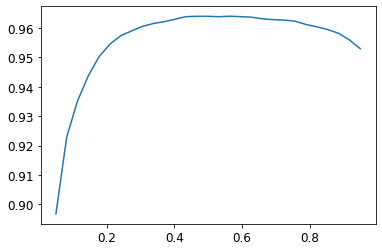

In [50]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs)

## Image Regression

* Independent variable is an image and dependent variable is one or more floats.
* We work with a keypoint model. We will predict two values for each image: row and column of the face center.

In [53]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [54]:
Path.BASE_PATH = path

In [55]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

In [56]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

In [58]:
img_files = get_image_files(path)
def img2pose(x):
  return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[2])

Path('19/frame_00147_pose.txt')

In [59]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

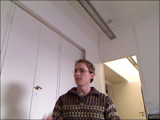

In [60]:
im.to_thumb(160)

In [61]:
# code to extract the head center point
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)

def get_ctr(f):
  ctr = np.genfromtxt(img2pose(f), skip_header=3)
  c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
  c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
  return tensor([c1,c2])

In [62]:
# function returns the coordinates as a tensor of two items
get_ctr(img_files[0])

tensor([338.1125, 287.5233])

In [63]:
# get_ctr is passed to DataBloack as get_y
# We do not use a RandomSplitter, as the same people appear in multiple images
# in this dataset. We create a splitter function returning True for one person.
# We use a PointBlock so that fastai knows that the labels represent 
# coordinates.

In [64]:
biwi = DataBlock(
    blocks = (ImageBlock, PointBlock),
    get_items = get_image_files,
    get_y = get_ctr,
    splitter = FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms = [*aug_transforms(size=(240,320)),
                  Normalize.from_stats(*imagenet_stats)]
)

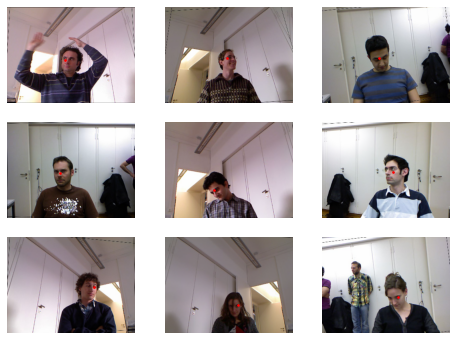

In [65]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [66]:
# Looking at tensors
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [67]:
# one row from dependent variable
yb[0]

tensor([[ 0.0169, -0.0575]], device='cuda:0')

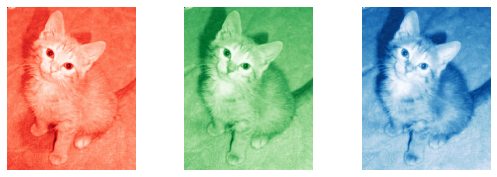

In [69]:
# Color picture is rank-3 tensor.

im = image2tensor(Image.open('chapter1_cat_example.jpg'))
_, axs = subplots(1,3)
for bear, ax, color in zip(im, axs, ('Reds', 'Greens', 'Blues')):
  show_image(255-bear, ax=ax, cmap=color)

In [70]:
yb[0]

tensor([[ 0.0169, -0.0575]], device='cuda:0')

## Training a Model

In [71]:
# coordinates in fastai and PyTorch rescaled to between -1 and +1
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

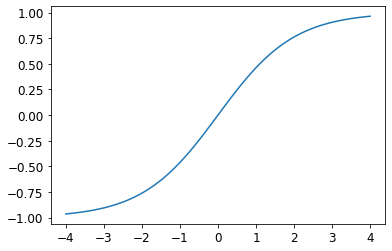

In [75]:
plot_function(partial(sigmoid_range, low=-1, high=1), min=-4, max=4)

In [76]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.04786301031708717)

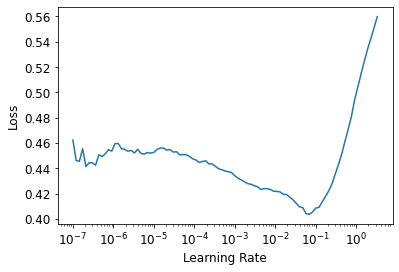

In [77]:
learn.lr_find()

In [79]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.048697,0.004205,02:22


epoch,train_loss,valid_loss,time
0,0.008132,0.004117,02:27
1,0.002859,0.000264,02:27
2,0.001421,0.000099,02:27


In [80]:
math.sqrt(0.000099)

0.0099498743710662

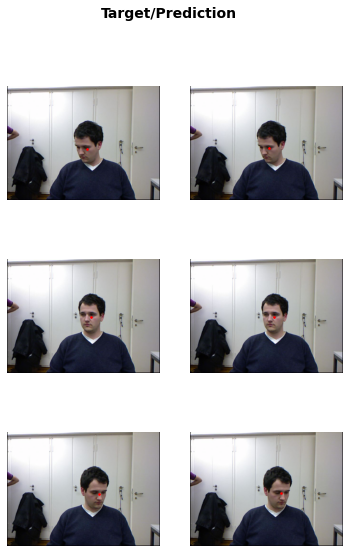

In [84]:
learn.show_results(ds_idx=1, max_n=10)

## Questionnaire

How could multi-label classification improve the usability of the bear classifier? Instead of being forced to choose one of 3 categories, we could have the model choose nothing.

How do we encode the dependent variable in a multi-label classification problem? We encode it as a one-hot encoded vector.

How do you access the rows and columns of a DataFrame as if it were a matrix? We can use `df.iloc[rows, columns]`

How do you get a column by name from a DataFrame? `df['colname']`

What is the difference between a Dataset and DataLoader? Dataset is tuple containing independent and dependent variables. DataLoader is an iterator that provides a stream of mini-batches. 

What does a Datasets object normally contain? It contains a training Dataset and validation Dataset.

What does a DataLoaders object normally contain? It contains training DataLoader and validation DataLoader.

What does lambda do in Python? Used to create one-line, anonymous functions

What are the methods to customize how the independent and dependent variables are created with the data block API? These methods are `get_x` and `get_y`.

Why is softmax not an appropriate output activation function when using a one-hot-encoded target? Softmax requires all predictions to sum to 1 and pushes one activation to be larger the others. This doesn't work with one-hot encoded target where multiple categories are coded as "1".

Why is nll_loss not an appropriate loss function when using a one-hot-encoded target? nll_loss makes sense for one activation but not multiple activations.

What is the difference between nn.BCELoss and nn.BCEWithLogitsLoss? The latter adds sigmoid transformation before doing binary cross-entropy.

Why can’t we use regular accuracy in a multi-label problem? Accuracy tends to work when we have 1 class that has the highest activation. However, there could be multiple activations with multi-label problem. In our multi-label example, we used a threshold as part of the accuracy metric.

When is it OK to tune a hyperparameter on the validation set? In our example, we were faced with the question of which threshold to choose to improve accuracy metric. Because we had a smooth curve and did not pick an inappropriate outlier, it was fine.

How is y_range implemented in fastai? (See if you can implement it yourself and test it without peeking!)

What is a regression problem? What loss function should you use for such a problem? Regression problem is prediction on float values. For regression problems, we typically use MSELoss.

What do you need to do to make sure the fastai library applies the same data augmentation to your input images and your target point coordinates? Make PointBlock the second block in the DataBlock.